In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

from torchvision import transforms
from torchvision import datasets
import torchvision

# Load data properly

Also define a function retrieving all dataloaders (training, validation and test).

In [3]:
transformer = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
music_dataset = datasets.ImageFolder("./Data/genres_music_image_30s_filtered/", transform=transformer)

def get_dataloader(dataset, batch_size):
    """
        Return train validation and test dataloader
    """
    test_split = int(len(dataset)*0.85) 
    train_split = int(len(dataset)*0.7)

    # Shuffle dataset
    np.random.seed(123) # For reproductible results
    shuffled_idx = np.arange(len(dataset))
    np.random.shuffle(shuffled_idx)

    relevant_train_indices = shuffled_idx[:train_split]
    relevant_val_indices = shuffled_idx[train_split:test_split]
    relevant_test_indices = shuffled_idx[test_split:]

    # Create training DataLoader set
    train_sampler = torch.utils.data.SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
                              
    # Create validation DataLoader set
    val_sampler = torch.utils.data.SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=val_sampler)
                            
    # Create test DataLoader set
    test_sampler = torch.utils.data.SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)

    return train_loader, val_loader, test_loader

## Define useful functions to plot and save training curve

In [4]:
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    train_acc = np.loadtxt("{}_train_acc.csv".format(path))
    val_acc = np.loadtxt("{}_val_acc.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Accuracy")
    n = len(train_acc) # number of epochs
    plt.plot(range(1,n+1), train_acc, label="Train")
    plt.plot(range(1,n+1), val_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    # plt.savefig(path.replace(".", ",") + "_train_val_err")
    plt.show()

    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    # plt.savefig(path.replace(".", ",") + "_train_val_loss")
    plt.show()


def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values
    Args:
        name: name of the model
        batch_size: size of the batch used during training
        learning_rate: learning rate value used during training
        epoch: epoch value
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format( name,
                                                    batch_size,
                                                    learning_rate,
                                                    epoch)
    return path

# Define model

Define model class as well as train and evaluate functions, very useful to train easily our model by just tweaking the hyperparameters.

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [6]:
# TRANSFER LEARNING
alexnet = torchvision.models.alexnet(weights='DEFAULT')
alexnet = alexnet.to(device)

In [7]:
class MusicNetTF(nn.Module):
    def __init__(self):
        super(MusicNetTF, self).__init__()
        self.name = "musicnet_tf_30s"
        self.fc1 = nn.Linear(256*10*14, 250)
        self.fc2 = nn.Linear(250, 10)  # Output layer with 10 classes

    def forward(self, x):
        x = x.view(-1, 256*10*14)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1)
        return x

# Train CNN model

In [8]:
def train_tf(net, dataset, batch_size=1, learning_rate=0.01, num_epochs=10):
    train_loader, val_loader, _ = get_dataloader(dataset, batch_size=batch_size)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=0.001) # weight decay ensures weights are not too high -> can prevent early overfitting

    train_acc = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_acc = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    for epoch in range(num_epochs):
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data[0].to(device), data[1].to(device)
            # Compute features with alexnet
            features = alexnet.features(inputs)
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            corr = (torch.argmax(outputs,1) != labels)
            total_train_err += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_acc[epoch] = 1 - (float(total_train_err) / total_epoch)
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_acc[epoch], val_loss[epoch] = evaluate_tf(net, val_loader, criterion)
        print(("Epoch {}: Train acc: {}, Train loss: {} |"+ "Val acc: {}, Val loss: {}").format(
                epoch + 1,
                train_acc[epoch],
                train_loss[epoch],
                val_acc[epoch],
                val_loss[epoch])
            )
    # Save the trained model to a file
    model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
    torch.save(net.state_dict(), model_path)
    print('Finished Training')
    
    # Write the train/test loss/err into CSV file for plotting later
    np.savetxt("{}_train_acc.csv".format(model_path), train_acc)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_acc.csv".format(model_path), val_acc)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

def evaluate_tf(net, loader, criterion):
    """ Evaluate the network on the validation set.

    Args:
        loader: PyTorch data loader for the validation set
        criterion: The loss function
    Returns:
        acc: A scalar for the avg classification accuracy over the validation set
        loss: A scalar for the average loss function over the validation set
    """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        # Compute features with alexnet
        features = alexnet.features(inputs)
        outputs = net(features)
        loss = criterion(outputs, labels)
        corr = (torch.argmax(outputs,1) != labels)
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    acc = 1 - err
    return acc, loss

Epoch 1: Train acc: 0.37768240343347637, Train loss: 1.7759077982469038 |Val acc: 0.5133333333333333, Val loss: 1.4249545097351075
Epoch 2: Train acc: 0.6051502145922747, Train loss: 1.152265491810712 |Val acc: 0.56, Val loss: 1.276876449584961
Epoch 3: Train acc: 0.7052932761087267, Train loss: 0.8976337530396201 |Val acc: 0.6333333333333333, Val loss: 1.1368093848228455
Epoch 4: Train acc: 0.7968526466380543, Train loss: 0.7081951620903882 |Val acc: 0.5933333333333333, Val loss: 1.1580095529556274
Epoch 5: Train acc: 0.8569384835479256, Train loss: 0.5863648043437437 |Val acc: 0.6599999999999999, Val loss: 1.0643134832382202
Epoch 6: Train acc: 0.8855507868383405, Train loss: 0.4836567518385974 |Val acc: 0.6333333333333333, Val loss: 1.0650093674659729
Epoch 7: Train acc: 0.9227467811158798, Train loss: 0.4098546938462691 |Val acc: 0.6533333333333333, Val loss: 1.0452874302864075
Epoch 8: Train acc: 0.9513590844062947, Train loss: 0.35108520700172946 |Val acc: 0.6466666666666667, Val

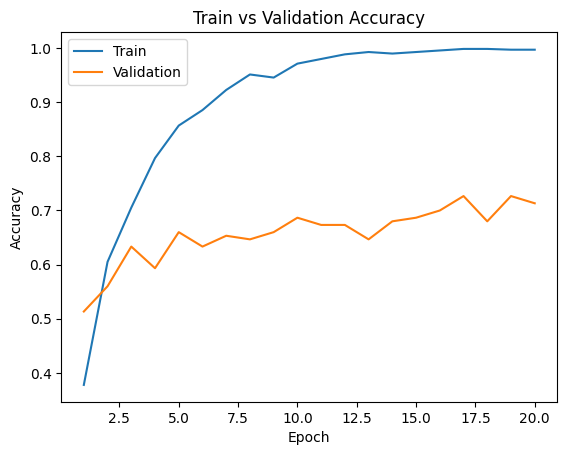

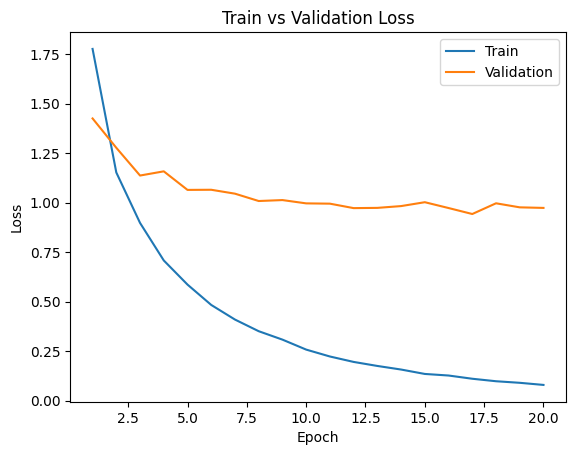

In [11]:
batch_size=32
learning_rate=0.00005
num_epochs=20

music_net_tf = MusicNetTF()
music_net_tf = music_net_tf.to(device)

train_tf(music_net_tf, music_dataset, batch_size=batch_size, learning_rate=learning_rate, num_epochs=num_epochs)

model_path = get_model_name("musicnet_tf_30s", batch_size, learning_rate, num_epochs-1)
plot_training_curve(model_path)

Epoch 1: Train acc: 0.2918454935622318, Train loss: 2.110353941267187 |Val acc: 0.3533333333333334, Val loss: 1.953956127166748
Epoch 2: Train acc: 0.5078683834048641, Train loss: 1.7190900715914639 |Val acc: 0.4866666666666667, Val loss: 1.6818597793579102
Epoch 3: Train acc: 0.5793991416309012, Train loss: 1.4700393189083447 |Val acc: 0.45999999999999996, Val loss: 1.5639065265655518
Epoch 4: Train acc: 0.6151645207439198, Train loss: 1.3143898357044568 |Val acc: 0.5066666666666666, Val loss: 1.4276812553405762
Epoch 5: Train acc: 0.6523605150214593, Train loss: 1.1822952899065884 |Val acc: 0.5466666666666666, Val loss: 1.3713895559310914
Epoch 6: Train acc: 0.6967095851216023, Train loss: 1.0856480110775342 |Val acc: 0.5466666666666666, Val loss: 1.297774863243103
Epoch 7: Train acc: 0.7195994277539342, Train loss: 1.0031748982993038 |Val acc: 0.5533333333333333, Val loss: 1.279770803451538
Epoch 8: Train acc: 0.7639484978540773, Train loss: 0.924098478122191 |Val acc: 0.58000000000

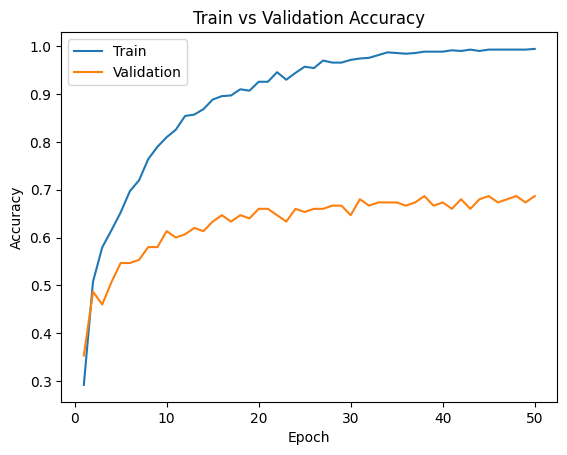

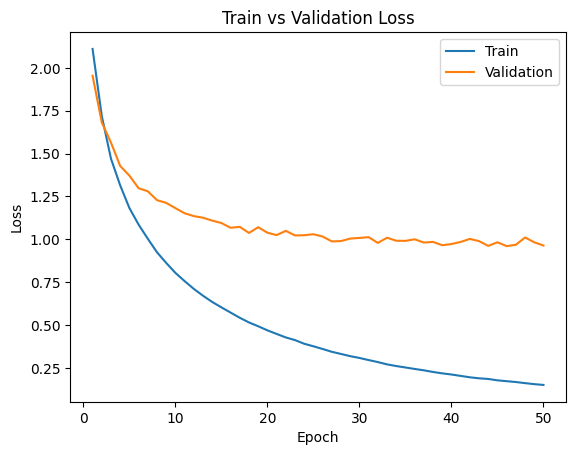

In [14]:
batch_size=32
learning_rate=0.00001
num_epochs=50

music_net_tf = MusicNetTF()
music_net_tf = music_net_tf.to(device)

train_tf(music_net_tf, music_dataset, batch_size=batch_size, learning_rate=learning_rate, num_epochs=num_epochs)

model_path = get_model_name("musicnet_tf_30s", batch_size, learning_rate, num_epochs-1)
plot_training_curve(model_path)

Epoch 1: Train acc: 0.37625178826895567, Train loss: 1.8866864280267195 |Val acc: 0.45999999999999996, Val loss: 1.5872479677200317
Epoch 2: Train acc: 0.5722460658082975, Train loss: 1.3142390196973628 |Val acc: 0.5333333333333333, Val loss: 1.3110461473464965
Epoch 3: Train acc: 0.6752503576537912, Train loss: 1.0386964624578303 |Val acc: 0.5933333333333333, Val loss: 1.1939162015914917
Epoch 4: Train acc: 0.7367668097281831, Train loss: 0.8877193873578851 |Val acc: 0.6133333333333333, Val loss: 1.1636975288391114
Epoch 5: Train acc: 0.7796852646638055, Train loss: 0.7711151865395632 |Val acc: 0.62, Val loss: 1.1511271953582765
Epoch 6: Train acc: 0.8483547925608012, Train loss: 0.6468571072274988 |Val acc: 0.6333333333333333, Val loss: 1.0746392130851745
Epoch 7: Train acc: 0.8841201716738197, Train loss: 0.5675768987698988 |Val acc: 0.64, Val loss: 1.0770786643028258
Epoch 8: Train acc: 0.9098712446351931, Train loss: 0.5038052160631526 |Val acc: 0.6266666666666667, Val loss: 1.023

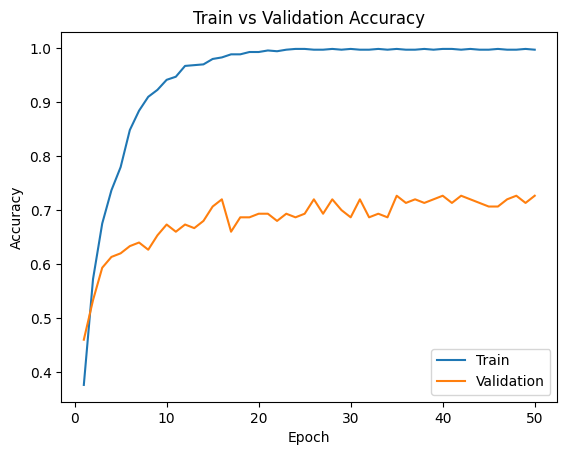

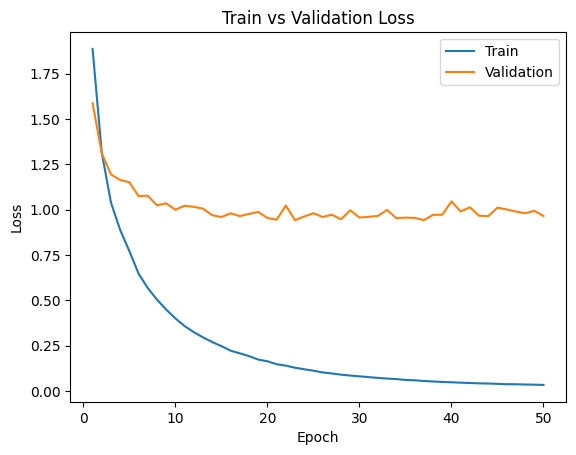

In [19]:
batch_size=32
learning_rate=0.00003
num_epochs=50

music_net_tf = MusicNetTF()
music_net_tf = music_net_tf.to(device)

train_tf(music_net_tf, music_dataset, batch_size=batch_size, learning_rate=learning_rate, num_epochs=num_epochs)

model_path = get_model_name("musicnet_tf_30s", batch_size, learning_rate, num_epochs-1)
plot_training_curve(model_path)

Epoch 1: Train acc: 0.3419170243204578, Train loss: 2.0118387151848185 |Val acc: 0.42000000000000004, Val loss: 1.7980821013450623
Epoch 2: Train acc: 0.5336194563662375, Train loss: 1.5386564379388636 |Val acc: 0.4666666666666667, Val loss: 1.5408862948417663
Epoch 3: Train acc: 0.5965665236051503, Train loss: 1.3040712462230162 |Val acc: 0.5733333333333333, Val loss: 1.378020715713501
Epoch 4: Train acc: 0.6738197424892705, Train loss: 1.1397289769216017 |Val acc: 0.5866666666666667, Val loss: 1.3218557715415955
Epoch 5: Train acc: 0.7110157367668097, Train loss: 1.0190502134236423 |Val acc: 0.5933333333333333, Val loss: 1.2516709566116333
Epoch 6: Train acc: 0.7525035765379113, Train loss: 0.9130932783538644 |Val acc: 0.6066666666666667, Val loss: 1.2094467461109162
Epoch 7: Train acc: 0.7796852646638055, Train loss: 0.833255531435663 |Val acc: 0.6133333333333333, Val loss: 1.1987670361995697
Epoch 8: Train acc: 0.8168812589413448, Train loss: 0.7605539072643627 |Val acc: 0.60666666

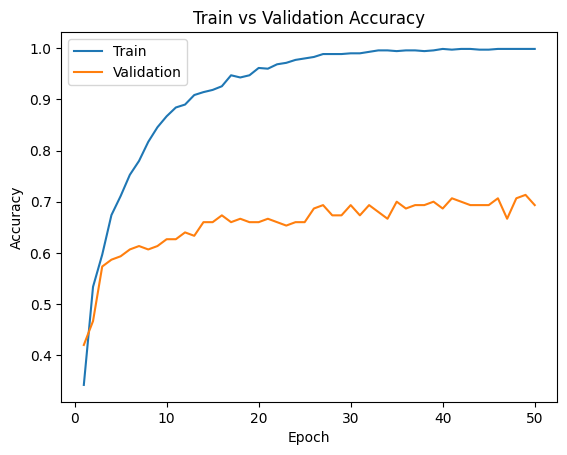

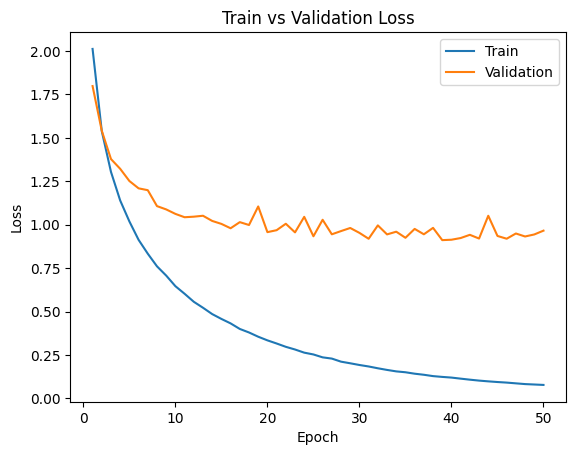

In [36]:
batch_size=16
learning_rate=0.00001
num_epochs=50

music_net_tf = MusicNetTF()
music_net_tf = music_net_tf.to(device)

train_tf(music_net_tf, music_dataset, batch_size=batch_size, learning_rate=learning_rate, num_epochs=num_epochs)

model_path = get_model_name("musicnet_tf_30s", batch_size, learning_rate, num_epochs-1)
plot_training_curve(model_path)

In [15]:
class MusicNetTFDropout(nn.Module):
    def __init__(self):
        super(MusicNetTFDropout, self).__init__()
        self.name = "musicnet_tf_dropout_30s"
        self.fc1 = nn.Linear(256*10*14, 250)
        self.fc2 = nn.Linear(250, 10)  # Output layer with 10 classes
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = x.view(-1, 256*10*14)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        x = x.squeeze(1)
        return x

Epoch 1: Train acc: 0.31616595135908443, Train loss: 1.9398877837441184 |Val acc: 0.43999999999999995, Val loss: 1.57955002784729
Epoch 2: Train acc: 0.49499284692417744, Train loss: 1.4460352550853381 |Val acc: 0.4866666666666667, Val loss: 1.4734605153401692
Epoch 3: Train acc: 0.5436337625178826, Train loss: 1.2480309876528652 |Val acc: 0.5733333333333333, Val loss: 1.4333573182423909
Epoch 4: Train acc: 0.6380543633762518, Train loss: 1.0621717355468057 |Val acc: 0.5533333333333333, Val loss: 1.2798019250233967
Epoch 5: Train acc: 0.6866952789699571, Train loss: 0.9515363465655934 |Val acc: 0.56, Val loss: 1.214840292930603
Epoch 6: Train acc: 0.7567954220314735, Train loss: 0.8242616924372587 |Val acc: 0.5800000000000001, Val loss: 1.2729949156443279
Epoch 7: Train acc: 0.7625178826895564, Train loss: 0.7307029149749062 |Val acc: 0.52, Val loss: 1.2890119155248005
Epoch 8: Train acc: 0.7939914163090129, Train loss: 0.7066833539442583 |Val acc: 0.5866666666666667, Val loss: 1.14846

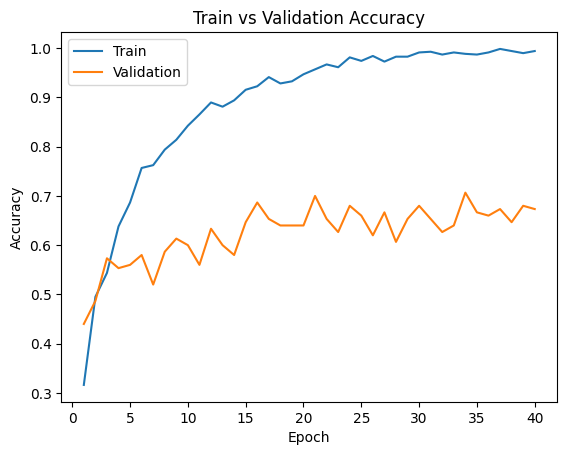

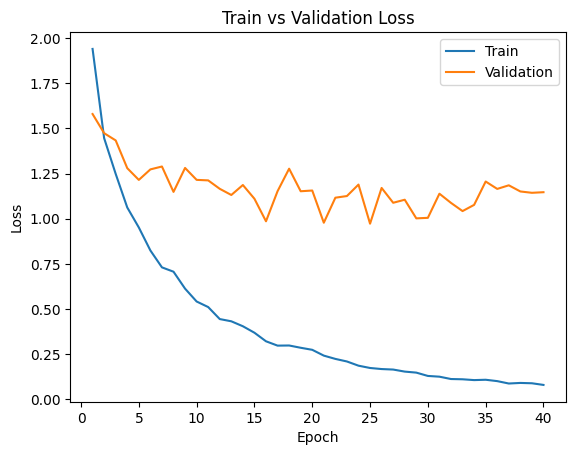

In [16]:
batch_size=64
learning_rate=0.00009
num_epochs=40

music_net_tf_drop = MusicNetTFDropout()
music_net_tf_drop = music_net_tf_drop.to(device)

train_tf(music_net_tf_drop, music_dataset, batch_size=batch_size, learning_rate=learning_rate, num_epochs=num_epochs)

model_path = get_model_name("musicnet_tf_dropout_30s", batch_size, learning_rate, num_epochs-1)
plot_training_curve(model_path)

Epoch 1: Train acc: 0.31616595135908443, Train loss: 1.9220355640758167 |Val acc: 0.31999999999999995, Val loss: 1.7210611820220947
Epoch 2: Train acc: 0.49499284692417744, Train loss: 1.4762442924759605 |Val acc: 0.43999999999999995, Val loss: 1.5246881246566772
Epoch 3: Train acc: 0.5765379113018598, Train loss: 1.2474318119612606 |Val acc: 0.5066666666666666, Val loss: 1.392589020729065
Epoch 4: Train acc: 0.6394849785407726, Train loss: 1.075636321848089 |Val acc: 0.5, Val loss: 1.3723638534545899
Epoch 5: Train acc: 0.7010014306151645, Train loss: 0.9584162885492499 |Val acc: 0.5266666666666666, Val loss: 1.3544115543365478
Epoch 6: Train acc: 0.7339055793991416, Train loss: 0.8393790586428209 |Val acc: 0.5333333333333333, Val loss: 1.3322656869888305
Epoch 7: Train acc: 0.7410586552217453, Train loss: 0.8088954768397592 |Val acc: 0.6133333333333333, Val loss: 1.1972423315048217
Epoch 8: Train acc: 0.7982832618025751, Train loss: 0.7135213098742745 |Val acc: 0.5933333333333333, Va

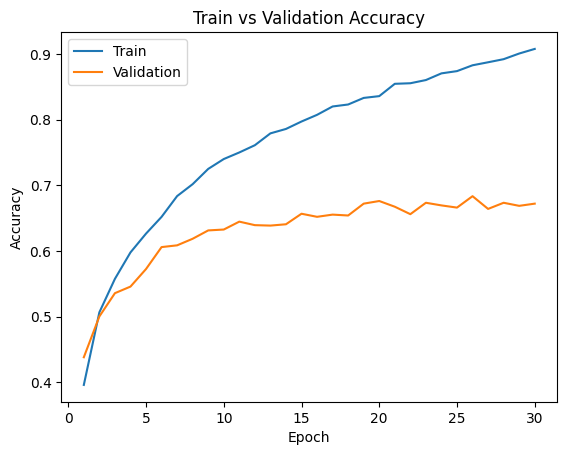

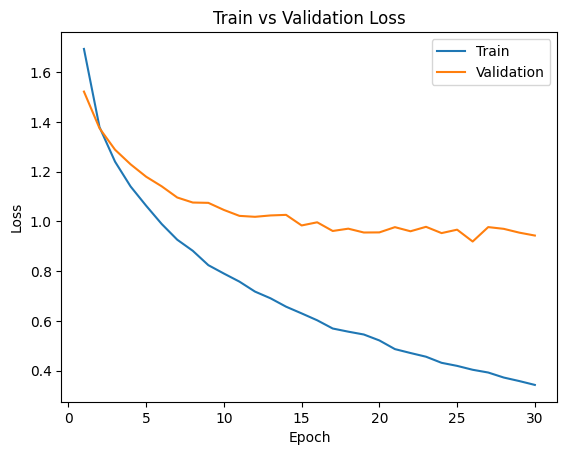

In [17]:
batch_size=32
learning_rate=0.00005
num_epochs=30

music_net_tf_drop = MusicNetTFDropout()
music_net_tf_drop = music_net_tf_drop.to(device)

train_tf(music_net_tf_drop, music_dataset, batch_size=batch_size, learning_rate=learning_rate, num_epochs=num_epochs)

model_path = get_model_name("musicnet_tf_dropout", batch_size, learning_rate, num_epochs-1)
plot_training_curve(model_path)

Epoch 1: Train acc: 0.2675250357653791, Train loss: 2.092817572030154 |Val acc: 0.33333333333333337, Val loss: 1.8888195276260376
Epoch 2: Train acc: 0.4434907010014306, Train loss: 1.6788750670172952 |Val acc: 0.43333333333333335, Val loss: 1.6047253847122191
Epoch 3: Train acc: 0.5278969957081545, Train loss: 1.4367753050544045 |Val acc: 0.4933333333333333, Val loss: 1.4727191209793091
Epoch 4: Train acc: 0.5851216022889842, Train loss: 1.307159586386247 |Val acc: 0.48, Val loss: 1.4307435035705567
Epoch 5: Train acc: 0.6280400572246065, Train loss: 1.1518421362746845 |Val acc: 0.54, Val loss: 1.3252166509628296
Epoch 6: Train acc: 0.6638054363376251, Train loss: 1.0637203021482988 |Val acc: 0.5333333333333333, Val loss: 1.3392547607421874
Epoch 7: Train acc: 0.6952789699570816, Train loss: 0.9802869124846025 |Val acc: 0.5266666666666666, Val loss: 1.3219656944274902
Epoch 8: Train acc: 0.7124463519313304, Train loss: 0.9160466275431893 |Val acc: 0.56, Val loss: 1.266071343421936
Epo

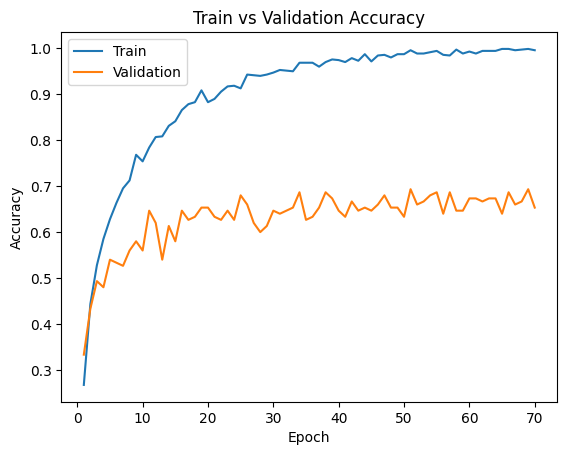

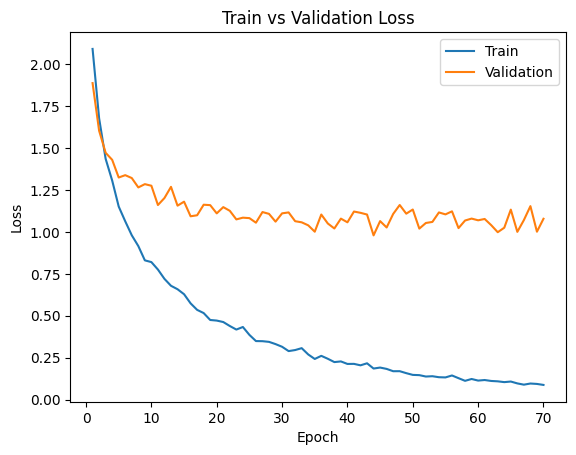

In [25]:
batch_size=32
learning_rate=0.00002
num_epochs=70

music_net_tf_drop = MusicNetTFDropout()
music_net_tf_drop = music_net_tf_drop.to(device)

train_tf(music_net_tf_drop, music_dataset, batch_size=batch_size, learning_rate=learning_rate, num_epochs=num_epochs)

model_path = get_model_name("musicnet_tf_dropout_30s", batch_size, learning_rate, num_epochs-1)
plot_training_curve(model_path)

In [28]:
class MusicNetTFMore(nn.Module):
    def __init__(self):
        super(MusicNetTFMore, self).__init__()
        self.name = "musicnet_tf_dropout_more_30s"
        self.fc1 = nn.Linear(256*10*14, 500)
        self.fc2 = nn.Linear(500, 10)  # Output layer with 10 classes
        self.dropout = nn.Dropout(p=0.4)

    def forward(self, x):
        x = x.view(-1, 256*10*14)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        x = x.squeeze(1)
        return x

Epoch 1: Train acc: 0.40629470672389123, Train loss: 1.7112765122543683 |Val acc: 0.4666666666666667, Val loss: 1.511966586112976
Epoch 2: Train acc: 0.5822603719599428, Train loss: 1.1698773923245342 |Val acc: 0.45999999999999996, Val loss: 1.492054396867752
Epoch 3: Train acc: 0.6824034334763949, Train loss: 0.9288776943629439 |Val acc: 0.5933333333333333, Val loss: 1.2557443022727965
Epoch 4: Train acc: 0.748211731044349, Train loss: 0.7517166672782465 |Val acc: 0.5800000000000001, Val loss: 1.229677528142929
Epoch 5: Train acc: 0.8183118741058655, Train loss: 0.604985270310532 |Val acc: 0.6733333333333333, Val loss: 1.1160462200641632
Epoch 6: Train acc: 0.8483547925608012, Train loss: 0.5050205181945454 |Val acc: 0.6666666666666667, Val loss: 1.1176867008209228
Epoch 7: Train acc: 0.899856938483548, Train loss: 0.4237318303097378 |Val acc: 0.64, Val loss: 1.1225471019744873
Epoch 8: Train acc: 0.9127324749642346, Train loss: 0.37015761130235414 |Val acc: 0.64, Val loss: 1.05282634

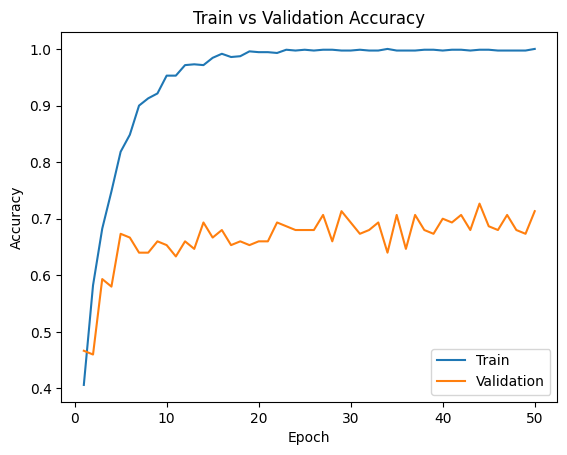

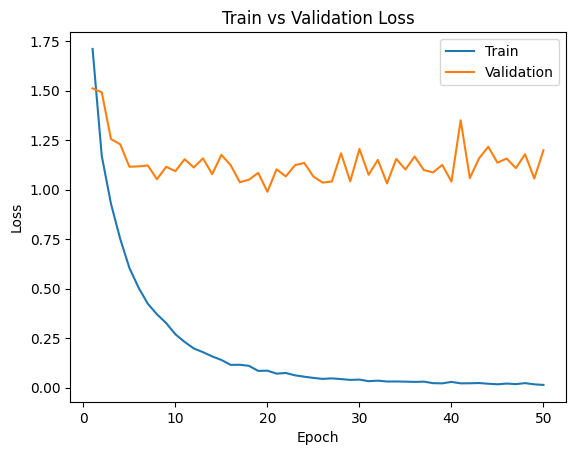

In [30]:
batch_size=16
learning_rate=0.00005
num_epochs=50

music_net_tf_more = MusicNetTFMore()
music_net_tf_more = music_net_tf_more.to(device)

train_tf(music_net_tf_more, music_dataset, batch_size=batch_size, learning_rate=learning_rate, num_epochs=num_epochs)

model_path = get_model_name("musicnet_tf_dropout_more_30s", batch_size, learning_rate, num_epochs-1)
plot_training_curve(model_path)

In [18]:
def retrieve_best_model(model_class, batch_size, lr, num_epochs):
    best_model = model_class()
    best_model = best_model.to(device)
    best_model_path = get_model_name(best_model.name, batch_size=batch_size, learning_rate=lr, epoch=num_epochs)
    best_model.load_state_dict(torch.load(best_model_path))
    return best_model

def testing(model_class, batch_size, lr, num_epochs, loader, criterion):
    # Load best model
    best_model = retrieve_best_model(model_class, batch_size, lr, num_epochs)

    # Evaluate
    test_acc, test_loss = evaluate_tf(best_model, loader, criterion)
    print(f"Test accuracy: {test_acc} | Test loss: {test_loss}")

In [38]:
batch_size=16
learning_rate=0.00001
num_epochs=50

criterion = nn.CrossEntropyLoss()
_, _, test_loader = get_dataloader(music_dataset, batch_size=batch_size)

testing(model_class=MusicNetTF,
        batch_size=batch_size,
        lr=learning_rate,
        num_epochs=num_epochs - 1,
        loader=test_loader,
        criterion=criterion
      )

Test accuracy: 0.6599999999999999 | Test loss: 0.9086759120225907


# Show confusion matrix

[Text(0.5, 47.7222222222222, 'Predicted'),
 Text(120.72222222222221, 0.5, 'Label')]

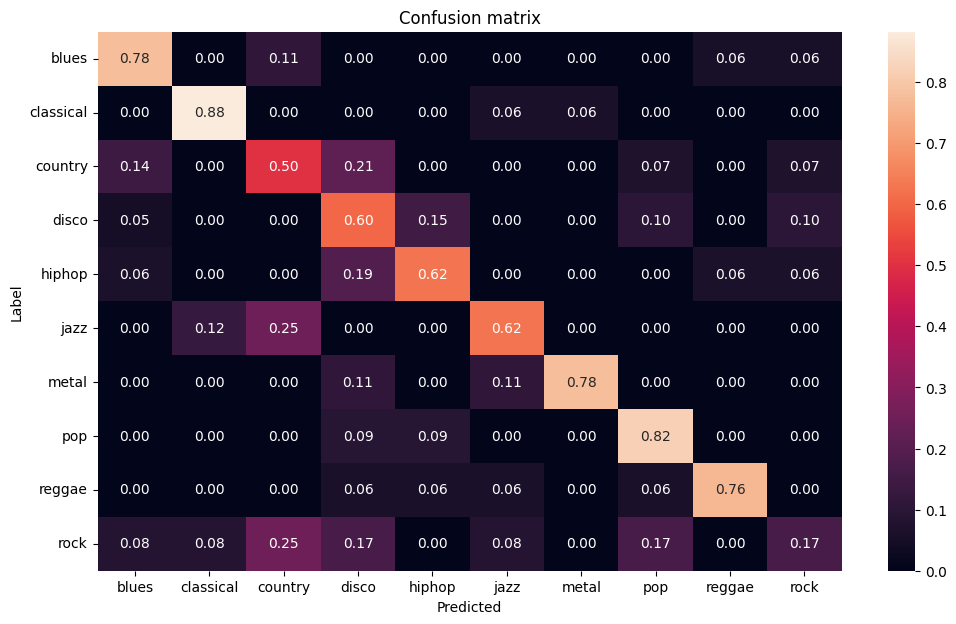

In [37]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

batch_size=16
learning_rate=0.00001
num_epochs=50
model_class = MusicNetTF

best_model = retrieve_best_model(model_class, batch_size, learning_rate, num_epochs-1)

y_pred = []
y_true = []
_, _, test_loader = get_dataloader(music_dataset, batch_size=batch_size)

# iterate over test data
for inputs, labels in test_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    # Compute features with alexnet
    features = alexnet.features(inputs)
    
    output = best_model(features) # Feed Network
    pred = torch.argmax(output,1).cpu().numpy()
    y_pred.extend(pred) # Save Prediction
    
    labels = labels.cpu().numpy()
    y_true.extend(labels) # Save Truth

# constant for classes
classes = ("blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock")

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
plt.title("Confusion matrix")
axis = sn.heatmap(df_cm, annot=True, fmt=".2f")
axis.set(xlabel="Predicted", ylabel="Label")
# plt.savefig('output.png')